# Introdução

Este notebook foi feito por Gabriel Matz visando o estudo dirigido para a prova de certificação oficial para o Tensorflow. A descrição da prova está no seguinte link:
https://www.tensorflow.org/certificate?hl=pt-br.

Utilizei como base os seguintes notebooks(além de sites variados e stack overflow para pequenas consultas):

1- https://github.com/mrdbourke/tensorflow-deep-learning

2-https://github.com/williamcwi/DeepLearning.AI-TensorFlow-Developer-Professional-Certificate

O conteúdo deste quinto notebook engloba a quinta parte de exigências da prova do Tensorflow, que estão descritas abaixo:

"
(5) Séries temporais, sequências e previsões

Você precisa entender como resolver problemas de séries temporais e previsões no TensorFlow. Você precisa saber como:

❏ Treinar, ajustar e utilizar modelos de séries temporais, sequência e previsão.

❏ Treinar modelos para prever valores tanto para séries temporais univariadas quanto multivariadas.

❏ Preparar dados para aprendizado de séries temporais.

❏ Compreender o Erro Médio Absoluto (EMA) e como ele pode ser usado para avaliar a precisão de modelos de sequência.

❏ Utilizar RNNs e CNNs para séries temporais, sequência e modelos de previsão.

❏ Identificar quando usar janelas deslizantes versus janelas centradas.

❏ Utilizar TensorFlow para previsão.

❏ Preparar características e rótulos.

❏ Identificar e compensar o viés de sequência.

❏ Ajustar dinamicamente a taxa de aprendizado em modelos de séries temporais, sequência e previsão."

# Desenvolvimento

In [ ]:
!nvidia-smi -L # checa se está usando gpu. Se estiver no collab, confira o ambiente de execução

/bin/bash: line 1: nvidia-smi: command not found


**❏ Utilizar TensorFlow para previsão.**

In [ ]:
import tensorflow as tf

print(tf.__version__)

2.15.0


Usarei os dados do histórico de preços do bitcoin encontrado em:
https://www.kaggle.com/datasets/ricksan4ez/092023-bitcoin-historical-data

In [ ]:
import pandas as pd
df = pd.read_csv("/content/Bitcoin Historical Data - Investing.com(1).csv",
                 names=["Date", "Price", "Open", "High", "Low", "Vol", "Change %"],
                 skiprows=1,  # Pular a primeira linha, que não contém dados
                 parse_dates=["Date"],
                 index_col=["Date"])
df.head()

,Price,Open,High,Low,Vol,Change %
Date,,,,,,
2023-08-31,"27,225.7","27,300.6","27,464.5","27,095.0",41.96K,-0.27%
2023-08-30,"27,298.8","27,723.9","27,757.3","27,043.2",46.54K,-1.53%
2023-08-29,"27,723.9","26,118.1","28,046.0","25,919.8",98.32K,6.14%
2023-08-28,"26,118.9","26,100.6","26,215.7","25,891.0",28.84K,0.07%
2023-08-27,"26,100.6","26,017.1","26,176.8","25,968.7",14.29K,0.32%


In [ ]:
import pandas as pd
df = pd.read_csv("/content/Bitcoin Historical Data - Investing.com(1).csv",
                 parse_dates=["Date"], # transformando em um formato interpretável
                 index_col=["Date"]) # coluna 1 é de datas
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-08-31,"27,225.7","27,300.6","27,464.5","27,095.0",41.96K,-0.27%
2023-08-30,"27,298.8","27,723.9","27,757.3","27,043.2",46.54K,-1.53%
2023-08-29,"27,723.9","26,118.1","28,046.0","25,919.8",98.32K,6.14%
2023-08-28,"26,118.9","26,100.6","26,215.7","25,891.0",28.84K,0.07%
2023-08-27,"26,100.6","26,017.1","26,176.8","25,968.7",14.29K,0.32%


In [ ]:
df.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2017-08-04,"2,878.5","2,810.0","2,892.7","2,779.5",68.76K,2.44%
2017-08-03,"2,810.0","2,720.5","2,822.9","2,717.6",68.10K,3.29%
2017-08-02,"2,720.5","2,747.0","2,773.8","2,668.9",81.82K,-0.96%
2017-08-01,"2,747.0","2,883.3","2,946.0","2,659.6",123.17K,-4.73%
2017-07-31,"2,883.3","2,766.5","2,916.3","2,723.1",91.12K,4.22%


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2223 entries, 2023-08-31 to 2017-07-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     2223 non-null   object
 1   Open      2223 non-null   object
 2   High      2223 non-null   object
 3   Low       2223 non-null   object
 4   Vol.      2223 non-null   object
 5   Change %  2223 non-null   object
dtypes: object(6)
memory usage: 121.6+ KB


Daqui já percebemos um problema de séries temporais:
poucos dados. Escolhendo agora as duas colunas que importam:

**❏ Preparar dados para aprendizado de séries temporais.**

In [ ]:
bitcoin_prices = pd.DataFrame(df["Price"])
bitcoin_prices.head()

,Price
Date,
2023-08-31,"27,225.7"
2023-08-30,"27,298.8"
2023-08-29,"27,723.9"
2023-08-28,"26,118.9"
2023-08-27,"26,100.6"


In [ ]:
# Mudando coluna para float
bitcoin_prices = bitcoin_prices['Price'].str.replace(',', '').astype(float)

<Axes: xlabel='Date'>

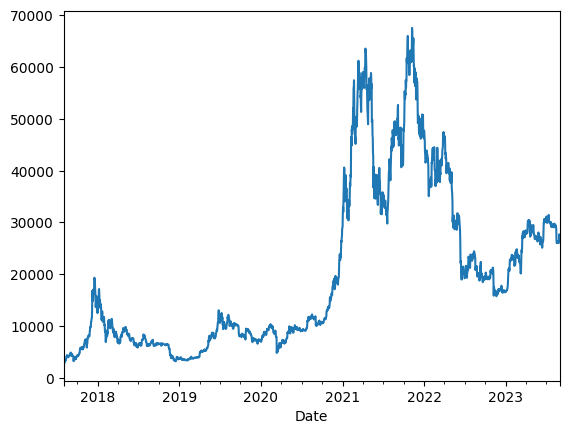

In [ ]:
bitcoin_prices.plot()

In [ ]:
bitcoin_prices.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2223 entries, 2023-08-31 to 2017-07-31
Series name: Price
Non-Null Count  Dtype  
--------------  -----  
2223 non-null   float64
dtypes: float64(1)
memory usage: 34.7 KB


No caso de séries temporais a divisão treino/teste não é aleatória, pegamos 20% finais e usamos pra treinar.

In [ ]:
# Extraindo os índices de tempo como matrizes numpy
timesteps = bitcoin_prices.index.to_numpy()

# Extraindo os preços como matrizes numpy
prices = bitcoin_prices.to_numpy()

# Imprimindo os primeiros 10 índices de tempo e preços
print("Timesteps:", timesteps[:10])
print("Prices:", prices[:10])

Timesteps: ['2023-08-31T00:00:00.000000000' '2023-08-30T00:00:00.000000000'
 '2023-08-29T00:00:00.000000000' '2023-08-28T00:00:00.000000000'
 '2023-08-27T00:00:00.000000000' '2023-08-26T00:00:00.000000000'
 '2023-08-25T00:00:00.000000000' '2023-08-24T00:00:00.000000000'
 '2023-08-23T00:00:00.000000000' '2023-08-22T00:00:00.000000000']
Prices: [27225.7 27298.8 27723.9 26118.9 26100.6 26017.1 26057.2 26177.  26436.2
 26039.9]


**❏ Preparar labels e features.**

In [ ]:
# Invertando para ir na ordem certa
timesteps = timesteps[::-1] # inverter para estar crescente
prices = prices[::-1]
split_size = int(0.8 * len(prices))
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]
len(X_train), len(X_test), len(y_train), len(y_test)

(1778, 445, 1778, 445)

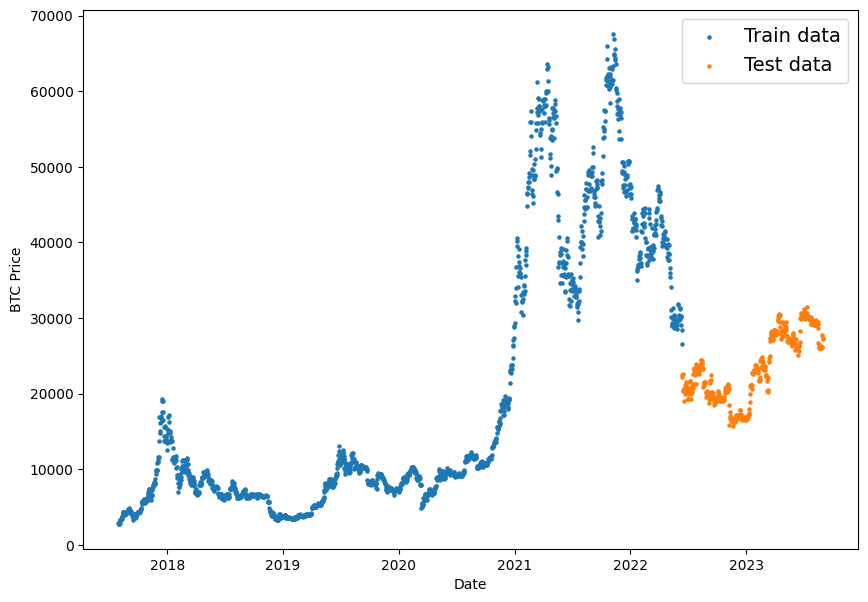

In [ ]:
# Plot correctly made splits
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

**❏ Compreender o Erro Médio Absoluto (EMA) e como ele pode ser usado para avaliar a precisão de modelos de sequência.**

Séries temporais tem muitas métricas diferentes. Abaixo cito as mais famosas:

**Métricas**

**1- Erros dependentes da escala**

Métricas que podem ser usadas para comparar valores de séries temporais e previsões que estão na mesma escala.
1.1- **MAE (erro médio absoluto)**

 O MAE é a média das diferenças absolutas entre os valores previstos (ŷi) e os valores reais (i). Ele fornece uma medida do erro médio entre a previsão e o valor real, independente da direção (positiva ou negativa) do erro. O MAE é fácil de interpretar, pois representa diretamente a magnitude média do erro.

1.2- **RMSE (erro quadrático médio)**

O RMSE é a raiz quadrada da média dos quadrados das diferenças entre os valores previstos e os valores reais. Ele penaliza erros maiores devido à operação de quadratura, tornando-o mais sensível a grandes desvios entre previsão e valor real. O RMSE é útil quando se deseja dar mais peso a erros maiores.

 **2- Erros percentuais**

Erros percentuais não têm unidades, isso significa que podem ser usados para comparar previsões em diferentes conjuntos de dados.

**2.1- MAPE (erro médio percentual absoluto)**

O MAPE é a média das diferenças percentuais absolutas entre os valores previstos e os valores reais, expressa como uma porcentagem. Ele fornece uma medida da precisão relativa da previsão em relação ao valor real, tornando-o útil para comparar o desempenho de diferentes modelos em diferentes conjuntos de dados.

**2.2- sMAPE (erro percentual absoluto médio simétrico)**

Não recomendado para uso por pesquisadores e livros

**3- Erros escalados**

Erros escalados são uma alternativa aos erros percentuais ao comparar o desempenho da previsão em diferentes séries temporais.

**3.1- MASE (erro médio absoluto escalado)**

 O MASE é uma medida relativa do erro médio absoluto da previsão em relação ao erro médio absoluto de uma previsão ingênua (como a média ou o último valor observado). Ele permite comparar o desempenho da previsão entre diferentes séries temporais e modelos, fornecendo uma medida de quão bem um modelo se sai em comparação com um modelo de referência simples.

In [ ]:
# Função bizu pra ver todas as métricas
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

**❏ Treinar, ajustar e utilizar modelos de séries temporais, sequência e previsão.**

In [ ]:
import numpy as np

In [ ]:
HORIZON = 1 # veja 1 dia no futuro
WINDOW_SIZE = 14 # use 2 semanas como base

In [ ]:
# Precisamos de funções auxiliares para criar as janelas.
def get_labelled_window(x, horizon=HORIZON):
  """
  Create labels for windowed dataset
  E.g if horizon = 1
  Input: [0, 1,  2, 3, 4, 5, 6, 7] -> Output: ([0, 1,  2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon]

In [ ]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size label.
  """
  # Cria janela
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # Índices
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of window size
  print(f"Window indexex:\n {window_indexes, window_indexes.shape}")
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_window(windowed_array, horizon=horizon)
  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

Window indexex:
 (array([[   0,    1,    2, ...,   12,   13,   14],
       [   1,    2,    3, ...,   13,   14,   15],
       [   2,    3,    4, ...,   14,   15,   16],
       ...,
       [2206, 2207, 2208, ..., 2218, 2219, 2220],
       [2207, 2208, 2209, ..., 2219, 2220, 2221],
       [2208, 2209, 2210, ..., 2220, 2221, 2222]]), (2209, 15))


In [ ]:
# View the first 3 windows & labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [2883.3 2747.  2720.5 2810.  2878.5 3262.8 3232.  3401.9 3429.4 3348.8
 3425.7 3654.4 3871.6 4062.6] -> Label: 4327.9
Window: [2747.  2720.5 2810.  2878.5 3262.8 3232.  3401.9 3429.4 3348.8 3425.7
 3654.4 3871.6 4062.6 4327.9] -> Label: 4161.7
Window: [2720.5 2810.  2878.5 3262.8 3232.  3401.9 3429.4 3348.8 3425.7 3654.4
 3871.6 4062.6 4327.9 4161.7] -> Label: 4387.4


In [ ]:
# Split
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1767, 442, 1767, 442)

**❏ Treinar modelos para prever valores tanto para séries temporais univariadas quanto multivariadas.**

**❏ Utilizar RNNs e CNNs para séries temporais, sequência e modelos de previsão.**

**CNN**

In [ ]:
# Reshape para funcionar com Conv
x = tf.constant(train_windows[0])
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [ ]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  tf.keras.layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_1.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=1000,
            verbose=1,
            validation_data=(test_windows, test_labels))

Epoch 1/1000
14/14 [==============================] - 1s 21ms/step - loss: 15684.1328 - val_loss: 13382.8828
Epoch 2/1000
14/14 [==============================] - 0s 5ms/step - loss: 15672.9365 - val_loss: 14610.5947
Epoch 3/1000
14/14 [==============================] - 0s 4ms/step - loss: 15680.2969 - val_loss: 13931.1494
Epoch 4/1000
14/14 [==============================] - 0s 4ms/step - loss: 15674.3125 - val_loss: 12690.9150
Epoch 5/1000
14/14 [==============================] - 0s 4ms/step - loss: 15661.1074 - val_loss: 13294.2500
Epoch 6/1000
14/14 [==============================] - 0s 6ms/step - loss: 15669.4424 - val_loss: 14599.4883
Epoch 7/1000
14/14 [==============================] - 0s 4ms/step - loss: 15667.5283 - val_loss: 14616.3574
Epoch 8/1000
14/14 [==============================] - 0s 5ms/step - loss: 15658.0186 - val_loss: 13167.0586
Epoch 9/1000
14/14 [==============================] - 0s 4ms/step - loss: 15621.6787 - val_loss: 12405.1689
Epoch 10/1000
14/14 [======

In [ ]:
model_1.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 14)             0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            9088      
                                                                 
 dense (Dense)               (None, 1, 1)              129       
                                                                 
Total params: 9217 (36.00 KB)
Trainable params: 9217 (36.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
model_1.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 14866.8486


14866.8486328125

In [ ]:
model_1_preds = make_preds(model_4, test_windows)
model_1_preds[:10]
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_1_results

14/14 [==============================] - 0s 2ms/step


{'mae': 14864.034, 'mse': 232914700.0, 'rmse': 15261.543, 'mape': 63.45969}

Para este problema os resultados foram ruins. Faltou complexidade?

**RNN**

In [ ]:
tf.random.set_seed(42)

inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE))
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = tf.keras.layers.LSTM(128, activation="relu")(x) # tanh é ruim
output = tf.keras.layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=1000,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels))

Epoch 1/1000
14/14 [==============================] - 2s 28ms/step - loss: 17483.3516 - val_loss: 17385.9180
Epoch 2/1000
14/14 [==============================] - 0s 7ms/step - loss: 12409.6172 - val_loss: 11651.6016
Epoch 3/1000
14/14 [==============================] - 0s 7ms/step - loss: 7028.5234 - val_loss: 4010.2275
Epoch 4/1000
14/14 [==============================] - 0s 7ms/step - loss: 2008.8752 - val_loss: 2306.4900
Epoch 5/1000
14/14 [==============================] - 0s 8ms/step - loss: 1646.4659 - val_loss: 1241.0565
Epoch 6/1000
14/14 [==============================] - 0s 8ms/step - loss: 1477.9052 - val_loss: 1092.8738
Epoch 7/1000
14/14 [==============================] - 0s 9ms/step - loss: 1416.3276 - val_loss: 1056.1971
Epoch 8/1000
14/14 [==============================] - 0s 7ms/step - loss: 1399.0060 - val_loss: 1057.1858
Epoch 9/1000
14/14 [==============================] - 0s 7ms/step - loss: 1388.0148 - val_loss: 1040.9282
Epoch 10/1000
14/14 [====================

In [ ]:
model_5.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 413.5504


413.5504455566406

In [ ]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

14/14 [==============================] - 0s 2ms/step


{'mae': 413.5504, 'mse': 385711.84, 'rmse': 621.05707, 'mape': 1.8146623}

Resultados bons

**❏ Identificar quando usar janelas deslizantes versus janelas centradas.**


A escolha entre usar janelas deslizantes (trailing windows) e janelas centradas (centered windows) em análise de séries temporais depende das características dos dados e dos objetivos específicos da análise.

**Janelas Deslizantes (Trailing Windows):**

Quando usar: As janelas deslizantes são comumente usadas em análises em tempo real ou previsões em tempo real, onde você deseja treinar seu modelo com dados históricos e prever os próximos pontos de dados à medida que se tornam disponíveis.
Como funciona: As janelas deslizantes avançam ao longo do tempo em incrementos fixos, incluindo um conjunto fixo de observações anteriores em cada etapa. Por exemplo, ao prever o preço das ações amanhã, você pode usar uma janela deslizante de 30 dias, atualizando-a a cada dia com os dados mais recentes.

**Janelas Centradas (Centered Windows):**

Quando usar: As janelas centradas são úteis quando você deseja prever um ponto central em uma série temporal, considerando tanto os dados passados quanto os futuros.

Como funciona: As janelas centradas dividem a série temporal em duas partes simétricas em torno do ponto de interesse (normalmente o ponto que você deseja prever). Isso permite que o modelo leve em consideração tanto os dados anteriores quanto os futuros ao fazer a previsão.

Já fizemos exemplos com janela deslizante.

**❏ Identificar e compensar o viés de sequência.**

O viés de sequência ocorre quando o desempenho do modelo é influenciado pela ordem em que os dados são apresentados ao modelo durante o treinamento ou inferência. Algumas abordagens para identificar e compensar o viés de sequência:

Aleatoriedade na ordem dos dados de treinamento para evitar que o modelo aprenda padrões específicos da sequência.

Em vez de usar janelas deslizantes fixas, introduza aleatoriedade na seleção das janelas deslizantes, permitindo que o modelo veja uma variedade de sequências durante o treinamento.

Use técnicas de regularização, como dropout ou regularização L1/L2, para ajudar o modelo a generalizar melhor e reduzir a sensibilidade à ordem dos dados.


No tensorflow...

**❏ Ajustar dinamicamente a taxa de aprendizado em modelos de séries temporais, sequência e previsão.**

# Extras úteis

**Multivariado**

Adicionando o block reward na previsão...